In [1]:
import pandas as pd
import requests
import numpy as np
import json
idx = pd.IndexSlice

In [2]:
appid = open('key_estat.txt').readlines()[0]

# 1. Download data

In [3]:
def download_series(series_id):
    url = f'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData?appId={appid}&lang=E&statsDataId={series_id}&metaGetFlg=Y&cntGetFlg=N&explanationGetFlg=Y&annotationGetFlg=Y&sectionHeaderFlg=1&replaceSpChars=0'
    r = requests.get(url)
    json_data = json.loads(r.text)
    return json_data

In [4]:
res = download_series('0003427113')

# 2. Convert json to pandas

In [5]:
def convert_pandas(json_data):
    data_dict = []
    for data in res['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE']:
   
        data_dict.append([data['@area'], data['@time'], data['@cat01'], data['$']])
    
    df =pd.DataFrame(data_dict)
    
    df.columns = ['region','date','category','value']
    df.date = [x[:4] + '-' + x[-2:] + '-01'  for x in df.date]
    
    mask = []
    for x in df.date:
        if '-00-' in x:
            mask.append(False)
        else:
            mask.append(True)
    
    df = df.loc[mask,:]
    df.date = pd.to_datetime(df.date)
    df.value = df.value.astype(float)
    df.set_index(['region','date'], inplace=True)
    
    
    return df

In [6]:
df = convert_pandas(res)
df.head(2)

category  value
region date                      
13A01  2021-11-01     0001  100.0
       2021-10-01     0001   99.9

# 3. Show Nationwide CPI only

## 3.1 Convert area code to name

In [7]:
areas = {}
for item in res['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']:
    if item['@id']=='area':
        for code in item['CLASS']:
            areas.update({code['@code'] : code['@name']})
areas['00000']

'All Japan'

In [8]:
cats ={}
for item in res['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']:
    if item['@id']=='cat01':
        for code in item['CLASS']:
            cats.update({code['@code'] : code['@name']})
cats['0001']

'All items'

## 3.2 Map new data
### 3.2.1 Overwrite multicolumn index

In [9]:
new_index = df.index.get_level_values(0).map(areas)
new_index[:3]

Index(['Ku-area of Tokyo', 'Ku-area of Tokyo', 'Ku-area of Tokyo'], dtype='object', name='region')

In [10]:
def edit_multicol(df, level, new_name):
    
    if level == 0:
        df.index = pd.MultiIndex.from_arrays([
            new_name,
            df.index.get_level_values(1)
        ])
    else:
         df.index = pd.MultiIndex.from_arrays([
            df.index.get_level_values(0),
            new_name,
        ])
    
    return df

In [11]:
df = edit_multicol(df, 0, new_index)
df.head(3)

category  value
region           date                      
Ku-area of Tokyo 2021-11-01     0001  100.0
                 2021-10-01     0001   99.9
                 2021-09-01     0001  100.1

### 3.2.2 Map categories

In [12]:
df.category = df.category.map(cats)
df.head(2)

category  value
region           date                        
Ku-area of Tokyo 2021-11-01  All items  100.0
                 2021-10-01  All items   99.9

## 3.3 Slice

### 3.3.1 All items

In [13]:
# Row slice
mask_row = df.category == 'All items'
df_all = df.loc[mask_row.values,:]
df_all.head(2)

category  value
region           date                        
Ku-area of Tokyo 2021-11-01  All items  100.0
                 2021-10-01  All items   99.9

### 3.3.2 All Japan

In [14]:
df.index.get_level_values(0).unique()[:3]

Index(['Ku-area of Tokyo', 'All Japan', 'Major cities'], dtype='object', name='region')

In [15]:
df_nationwide = df_all.loc[idx['All Japan',:], :]
df_nationwide.index = df_nationwide.index.droplevel(0)
df_nationwide.sort_index(inplace=True)
df_nationwide.head(2)

/Users/corybaird/opt/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:5579: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().sort_index(


,category,value
date,,
1970-01-01,All items,30.3
1970-02-01,All items,30.3


#### 3.2.2.1 Convert to y-o-y changes

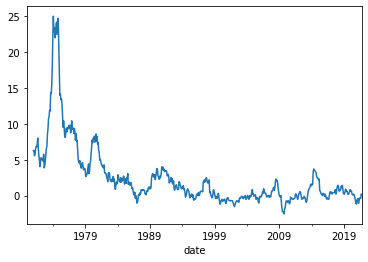

In [16]:
df_nationwide.value.pct_change(12).multiply(100).plot();